In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
player_totals = pd.read_csv('archive/Player Totals.csv')
player_per_game = pd.read_csv('archive/Player Per Game.csv')
player_shooting = pd.read_csv('archive/Player Shooting.csv')
advanced = pd.read_csv('archive/Advanced.csv')
opponent_stats = pd.read_csv('archive/Opponent Stats Per Game.csv')

# Display the first few rows of each dataset (optional for debugging)
print("Player Per Game Data:", player_per_game.head(), sep="\n")
print("Advanced Stats Data:", advanced.head(), sep="\n")
print("Opponent Stats Data:", opponent_stats.head(), sep="\n")


Player Per Game Data:
   seas_id  season  player_id         player  birth_year pos   age  \
0    31871    2025       5025     A.J. Green         NaN  SG  25.0   
1    31872    2025       5210     AJ Johnson         NaN  SG  20.0   
2    31873    2025       4219   Aaron Gordon         NaN  PF  29.0   
3    31874    2025       4582  Aaron Holiday         NaN  PG  28.0   
4    31875    2025       4805  Aaron Nesmith         NaN  SF  25.0   

   experience   lg   tm  ...  ft_percent  orb_per_game  drb_per_game  \
0           3  NBA  MIL  ...       0.833           0.2           1.8   
1           1  NBA  MIL  ...         NaN           0.0           0.3   
2          11  NBA  DEN  ...       0.846           2.7           4.0   
3           7  NBA  HOU  ...       0.714           0.0           0.8   
4           5  NBA  IND  ...       0.846           0.7           3.3   

   trb_per_game  ast_per_game  stl_per_game  blk_per_game  tov_per_game  \
0           2.0           0.9           0.6      

In [35]:
# Drop irrelevant columns with too many missing values
irrelevant_columns = [
    'birth_year', 'gs', 'x3p_percent', 'corner_3_point_percent',
    'num_heaves_attempted', 'num_heaves_made', 'percent_corner_3s_of_3pa'
]
player_per_game.drop(columns=irrelevant_columns, inplace=True, errors='ignore')
player_shooting.drop(columns=irrelevant_columns, inplace=True, errors='ignore')
advanced.drop(columns=irrelevant_columns, inplace=True, errors='ignore')
opponent_stats.drop(columns=['abbreviation'], inplace=True, errors='ignore')

# Impute missing values for numeric columns only
def impute_missing_values(df):
    numeric_columns = df.select_dtypes(include=['number']).columns
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())
    return df

player_per_game = impute_missing_values(player_per_game)
player_shooting = impute_missing_values(player_shooting)
advanced = impute_missing_values(advanced)
opponent_stats = impute_missing_values(opponent_stats)

# Validate missing values after imputation
print("Remaining Missing Values in Player Per Game Data:", player_per_game.isnull().sum(), sep="\n")


Remaining Missing Values in Player Per Game Data:
seas_id          0
season           0
player_id        0
player           0
pos              0
age              0
experience       0
lg               0
tm               0
g                0
mp_per_game      0
fg_per_game      0
fga_per_game     0
fg_percent       0
x3p_per_game     0
x3pa_per_game    0
x2p_per_game     0
x2pa_per_game    0
x2p_percent      0
e_fg_percent     0
ft_per_game      0
fta_per_game     0
ft_percent       0
orb_per_game     0
drb_per_game     0
trb_per_game     0
ast_per_game     0
stl_per_game     0
blk_per_game     0
tov_per_game     0
pf_per_game      0
pts_per_game     0
dtype: int64


In [33]:
# Mapping team names to abbreviations for opponent_stats for current teams
team_mapping = {
    'Atlanta Hawks': 'ATL',
    'Boston Celtics': 'BOS',
    'Brooklyn Nets': 'BRK',
    'Charlotte Hornets': 'CHO',
    'Chicago Bulls': 'CHI',
    'Cleveland Cavaliers': 'CLE',
    'Dallas Mavericks': 'DAL',
    'Denver Nuggets': 'DEN',
    'Detroit Pistons': 'DET',
    'Golden State Warriors': 'GSW',
    'Houston Rockets': 'HOU',
    'Indiana Pacers': 'IND',
    'Los Angeles Clippers': 'LAC',
    'Los Angeles Lakers': 'LAL',
    'Memphis Grizzlies': 'MEM',
    'Miami Heat': 'MIA',
    'Milwaukee Bucks': 'MIL',
    'Minnesota Timberwolves': 'MIN',
    'New Orleans Pelicans': 'NOP',
    'New York Knicks': 'NYK',
    'Oklahoma City Thunder': 'OKC',
    'Orlando Magic': 'ORL',
    'Philadelphia 76ers': 'PHI',
    'Phoenix Suns': 'PHX',
    'Portland Trail Blazers': 'POR',
    'Sacramento Kings': 'SAC',
    'San Antonio Spurs': 'SAS',
    'Toronto Raptors': 'TOR',
    'Utah Jazz': 'UTA',
    'Washington Wizards': 'WAS'
}

# Map 'team' to 'tm' in opponent_stats
if 'team' in opponent_stats.columns:
    opponent_stats['tm'] = opponent_stats['team'].map(team_mapping)

# Check for unmapped teams
unmapped_teams = opponent_stats[opponent_stats['tm'].isnull()]['team'].unique()
if len(unmapped_teams) > 0:
    print("Unmapped Teams:", unmapped_teams)
    # Add missing teams to the mapping if needed
    team_mapping.update({
        # Add missing team mappings here
    })
    opponent_stats['tm'] = opponent_stats['team'].map(team_mapping)

# Verify 'tm' column in opponent_stats
if 'tm' not in opponent_stats.columns:
    print("Error: 'tm' column is missing from opponent_stats.")
else:
    print("Team mapping successful. No missing 'tm' values:", opponent_stats['tm'].isnull().sum() == 0)



Unmapped Teams: ['League Average' 'Charlotte Bobcats' 'New Orleans Hornets'
 'New Jersey Nets' 'Seattle SuperSonics'
 'New Orleans/Oklahoma City Hornets' 'Vancouver Grizzlies'
 'Washington Bullets' 'Kansas City Kings' 'San Diego Clippers'
 'New Orleans Jazz' 'Buffalo Braves' 'New York Nets' 'Kentucky Colonels'
 'San Diego Sails' 'Spirits of St. Louis' 'Utah Stars' 'Virginia Squires'
 'Kansas City-Omaha Kings' 'Memphis Sounds' 'San Diego Conquistadors'
 'Capital Bullets' 'Carolina Cougars' 'Denver Rockets' 'Memphis Tams'
 'Baltimore Bullets' 'Dallas Chaparrals' 'Cincinnati Royals'
 'The Floridians' 'Memphis Pros' 'Pittsburgh Condors' 'San Diego Rockets'
 'San Francisco Warriors' 'Texas Chaparrals' 'Los Angeles Stars'
 'Miami Floridians' 'New Orleans Buccaneers' 'Pittsburgh Pipers'
 'Washington Capitols' 'Houston Mavericks' 'Minnesota Pipers'
 'Oakland Oaks' 'Anaheim Amigos' 'Minnesota Muskies'
 'New Jersey Americans' 'St. Louis Hawks' 'Chicago Zephyrs'
 'Syracuse Nationals' 'Chicago Pac

In [39]:
# Extend team mapping with modern and historical teams
team_mapping.update({
    # Modern NBA teams
    'Atlanta Hawks': 'ATL',
    'Boston Celtics': 'BOS',
    'Brooklyn Nets': 'BRK',
    'Charlotte Hornets': 'CHO',
    'Chicago Bulls': 'CHI',
    'Cleveland Cavaliers': 'CLE',
    'Dallas Mavericks': 'DAL',
    'Denver Nuggets': 'DEN',
    'Detroit Pistons': 'DET',
    'Golden State Warriors': 'GSW',
    'Houston Rockets': 'HOU',
    'Indiana Pacers': 'IND',
    'Los Angeles Clippers': 'LAC',
    'Los Angeles Lakers': 'LAL',
    'Memphis Grizzlies': 'MEM',
    'Miami Heat': 'MIA',
    'Milwaukee Bucks': 'MIL',
    'Minnesota Timberwolves': 'MIN',
    'New Orleans Pelicans': 'NOP',
    'New York Knicks': 'NYK',
    'Oklahoma City Thunder': 'OKC',
    'Orlando Magic': 'ORL',
    'Philadelphia 76ers': 'PHI',
    'Phoenix Suns': 'PHX',
    'Portland Trail Blazers': 'POR',
    'Sacramento Kings': 'SAC',
    'San Antonio Spurs': 'SAS',
    'Toronto Raptors': 'TOR',
    'Utah Jazz': 'UTA',
    'Washington Wizards': 'WAS',

    # Historical teams mapped to modern equivalents
    'New York Nets': 'BRK',  # Now Brooklyn Nets
    'Philadelphia Warriors': 'GSW',  # Now Golden State Warriors
    'Milwaukee Hawks': 'ATL',  # Now Atlanta Hawks
    'Indianapolis Olympians': None,  # Exclude
    'Tri-Cities Blackhawks': 'ATL',  # Now Atlanta Hawks
    'Chicago Zephyrs': 'CHI',  # Now Chicago Bulls
    'Chicago Packers': 'CHI',  # Now Chicago Bulls

    # Exclude non-teams
    'League Average': None  # Exclude this entry
})


opponent_stats = opponent_stats[~opponent_stats['team'].isin(defunct_teams)]

# Apply the updated team mapping
opponent_stats['tm'] = opponent_stats['team'].map(team_mapping)


In [40]:
# Check for teams still unmapped
unmapped_teams = opponent_stats[opponent_stats['tm'].isnull()]['team'].unique()
if len(unmapped_teams) > 0:
    print("Still Unmapped Teams:", unmapped_teams)
else:
    print("All teams successfully mapped!")


Still Unmapped Teams: ['League Average' 'Indianapolis Olympians']


In [62]:
# Remove 'League Average' and 'Indianapolis Olympians'
opponent_stats = opponent_stats[~opponent_stats['team'].isin(['League Average', 'Indianapolis Olympians'])]

# Apply the updated team mapping
opponent_stats['tm'] = opponent_stats['team'].map(team_mapping)

# Check for unmapped teams after filtering
unmapped_teams = opponent_stats[opponent_stats['tm'].isnull()]['team'].unique()
if len(unmapped_teams) > 0:
    print("Still Unmapped Teams:", unmapped_teams)
else:
    print("All teams successfully mapped!")


All teams successfully mapped!


In [63]:
# Identify valid team abbreviations from opponent_stats
valid_teams = opponent_stats['tm'].unique()

# Filter datasets to include only rows with valid team abbreviations
player_per_game = player_per_game[player_per_game['tm'].isin(valid_teams)]
advanced = advanced[advanced['tm'].isin(valid_teams)]

# Confirm the updated unique 'tm' values
print("Filtered 'tm' values in player_per_game:", player_per_game['tm'].unique())
print("Filtered 'tm' values in advanced:", advanced['tm'].unique())


Filtered 'tm' values in player_per_game: ['MIL' 'DEN' 'HOU' 'IND' 'OKC' 'CHI' 'PHI' 'BOS' 'MIA' 'SAC' 'WAS' 'DET'
 'LAC' 'GSW' 'POR' 'ORL' 'LAL' 'MIN' 'NOP' 'NYK' 'BRK' 'SAS' 'ATL' 'MEM'
 'CHO' 'DAL' 'UTA' 'TOR' 'CLE']
Filtered 'tm' values in advanced: ['MIL' 'DEN' 'HOU' 'IND' 'OKC' 'CHI' 'PHI' 'BOS' 'MIA' 'SAC' 'WAS' 'DET'
 'LAC' 'GSW' 'POR' 'ORL' 'LAL' 'MIN' 'NOP' 'NYK' 'BRK' 'SAS' 'ATL' 'MEM'
 'CHO' 'DAL' 'UTA' 'TOR' 'CLE']


In [65]:
# Ensure consistent types
player_per_game['season'] = player_per_game['season'].astype(str)
advanced['season'] = advanced['season'].astype(str)
opponent_stats['season'] = opponent_stats['season'].astype(str)

player_per_game['player_id'] = player_per_game['player_id'].astype(str)
advanced['player_id'] = advanced['player_id'].astype(str)

player_per_game['tm'] = player_per_game['tm'].astype(str)
advanced['tm'] = advanced['tm'].astype(str)
opponent_stats['tm'] = opponent_stats['tm'].astype(str)


In [66]:
# Check for exact matches in keys before merge
keys_player_advanced = set(zip(player_per_game['player_id'], player_per_game['season']))
keys_advanced_stats = set(zip(advanced['player_id'], advanced['season']))
keys_opponent_stats = set(zip(opponent_stats['tm'], opponent_stats['season']))

# Debug overlaps
print("Matching keys between player_per_game and advanced:", len(keys_player_advanced & keys_advanced_stats))
print("Matching keys between merged data and opponent_stats:", len(keys_player_advanced & keys_opponent_stats))


Matching keys between player_per_game and advanced: 20165
Matching keys between merged data and opponent_stats: 0


In [69]:
# Perform first merge
merged = pd.merge(player_per_game, advanced, on=['player_id', 'season'], how='inner')

# Check columns in the merged DataFrame
print("Columns after first merge:", merged.columns)

# Verify if 'tm' exists
if 'tm' in merged.columns:
    print("Unique 'tm' values in intermediate merge:", merged['tm'].unique())
else:
    print("'tm' column is missing after the first merge.")


Columns after first merge: Index(['seas_id_x', 'season', 'player_id', 'player_x', 'pos_x', 'age_x',
       'experience_x', 'lg_x', 'tm_x', 'g_x', 'mp_per_game', 'fg_per_game',
       'fga_per_game', 'fg_percent', 'x3p_per_game', 'x3pa_per_game',
       'x2p_per_game', 'x2pa_per_game', 'x2p_percent', 'e_fg_percent',
       'ft_per_game', 'fta_per_game', 'ft_percent', 'orb_per_game',
       'drb_per_game', 'trb_per_game', 'ast_per_game', 'stl_per_game',
       'blk_per_game', 'tov_per_game', 'pf_per_game', 'pts_per_game',
       'seas_id_y', 'player_y', 'pos_y', 'age_y', 'experience_y', 'lg_y',
       'tm_y', 'g_y', 'mp', 'per', 'ts_percent', 'x3p_ar', 'f_tr',
       'orb_percent', 'drb_percent', 'trb_percent', 'ast_percent',
       'stl_percent', 'blk_percent', 'tov_percent', 'usg_percent', 'ows',
       'dws', 'ws', 'ws_48', 'obpm', 'dbpm', 'bpm', 'vorp'],
      dtype='object')
'tm' column is missing after the first merge.


In [91]:
# Rename the appropriate 'tm' column back to 'tm'
merged.rename(columns={'tm_x': 'tm'}, inplace=True)  # If 'tm_x' is the column you want

# Drop redundant 'tm_y' column
if 'tm_y' in merged.columns:
    merged.drop(columns=['tm_y'], inplace=True)

# Verify the 'tm' column
print("Unique 'tm' values after renaming:", merged['tm'].unique())


Unique 'tm' values after renaming: ['MIL' 'DEN' 'HOU' 'IND' 'OKC' 'CHI' 'PHI' 'BOS' 'MIA' 'SAC' 'WAS' 'DET'
 'LAC' 'GSW' 'POR' 'ORL' 'LAL' 'MIN' 'NOP' 'NYK' 'BRK' 'SAS' 'ATL' 'MEM'
 'CHO' 'DAL' 'UTA' 'TOR' 'CLE']


In [73]:
# Merge with opponent_stats
data = pd.merge(merged, opponent_stats, on=['tm', 'season'], how='left')

# Validate the final merged dataset
print("Final Merged Data Columns:", data.columns)
print("Number of Rows in Final Merged Dataset:", data.shape[0])


Final Merged Data Columns: Index(['seas_id_x', 'season', 'player_id', 'player_x', 'pos_x', 'age_x',
       'experience_x', 'lg_x', 'tm', 'g_x', 'mp_per_game_x', 'fg_per_game',
       'fga_per_game', 'fg_percent', 'x3p_per_game', 'x3pa_per_game',
       'x2p_per_game', 'x2pa_per_game', 'x2p_percent', 'e_fg_percent',
       'ft_per_game', 'fta_per_game', 'ft_percent', 'orb_per_game',
       'drb_per_game', 'trb_per_game', 'ast_per_game', 'stl_per_game',
       'blk_per_game', 'tov_per_game', 'pf_per_game', 'pts_per_game',
       'seas_id_y', 'player_y', 'pos_y', 'age_y', 'experience_y', 'lg_y',
       'g_y', 'mp', 'per', 'ts_percent', 'x3p_ar', 'f_tr', 'orb_percent',
       'drb_percent', 'trb_percent', 'ast_percent', 'stl_percent',
       'blk_percent', 'tov_percent', 'usg_percent', 'ows', 'dws', 'ws',
       'ws_48', 'obpm', 'dbpm', 'bpm', 'vorp', 'lg', 'team', 'playoffs', 'g',
       'mp_per_game_y', 'opp_fg_per_game', 'opp_fga_per_game',
       'opp_fg_percent', 'opp_x3p_per_game', '

In [74]:
# Check missing values in the dataset
missing_values = data.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
Series([], dtype: int64)


Missing values detected in y_train. Imputing missing values...
Metrics for pts_per_game:
  Mean Squared Error: 0.6500833465588
  Mean Absolute Error: 0.5413628336781853
  R² Score: 0.9871259502869528
Metrics for trb_per_game:
  Mean Squared Error: 1.7514357369246687
  Mean Absolute Error: 0.9867712476555147
  R² Score: 0.7530092030113087
Metrics for ast_per_game:
  Mean Squared Error: 0.7350186223945436
  Mean Absolute Error: 0.5572042213563085
  R² Score: 0.8130469237370039
Metrics for stl_per_game:
  Mean Squared Error: 0.09506981844891338
  Mean Absolute Error: 0.19462739075094515
  R² Score: 0.5963447795607381

Comparison of Predicted and Actual Stats:
               player  season  pts_per_game_actual  pts_per_game_predicted  \
28    Anthony Edwards    2025                 27.7               27.276951   
130  Domantas Sabonis    2025                 20.4               20.232693   
229      Jayson Tatum    2025                 28.7               25.748929   
240      Jimmy Butler  

/var/folders/kj/wrj2qvqj34qfsgpmkp4htrd40000gn/T/ipykernel_53871/3585159678.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.fillna(y_train.mean(), inplace=True)


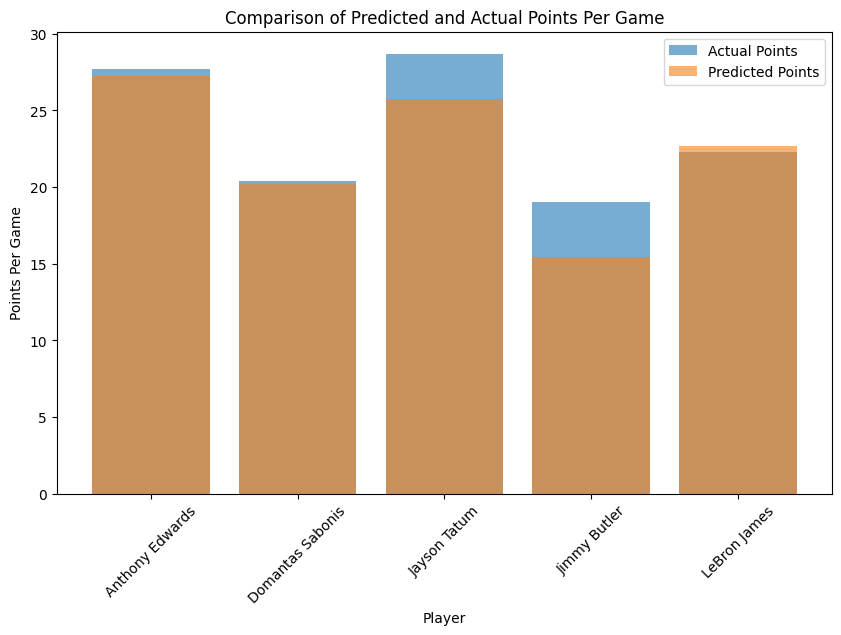

In [103]:
# Check for missing values in the target variables
if y_train.isnull().values.any():
    print("Missing values detected in y_train. Imputing missing values...")
    y_train.fillna(y_train.mean(), inplace=True)

if y_test.isnull().values.any():
    print("Missing values detected in y_test. Imputing missing values...")
    y_test.fillna(y_test.mean(), inplace=True)

# Train a multivariate regression model (Ridge for regularization)
ridge_model = MultiOutputRegressor(Ridge(alpha=1.0))
ridge_model.fit(X_train, y_train)

# Predict on test data
y_pred = ridge_model.predict(X_test)

# Evaluate model
evaluation_results = []
for i, target in enumerate(targets):
    mse = mean_squared_error(y_test[target], y_pred[:, i])
    mae = mean_absolute_error(y_test[target], y_pred[:, i])
    r2 = r2_score(y_test[target], y_pred[:, i])
    evaluation_results.append((target, mse, mae, r2))

# Display metrics
for target, mse, mae, r2 in evaluation_results:
    print(f"Metrics for {target}:")
    print(f"  Mean Squared Error: {mse}")
    print(f"  Mean Absolute Error: {mae}")
    print(f"  R² Score: {r2}")

# Compare predictions with actuals for key players
key_players = ['LeBron James', 'Anthony Edwards', 'Domantas Sabonis', 'Jayson Tatum', 'Jimmy Butler']
filtered_test_data = test_data[test_data['player_x'].isin(key_players)]

comparison = pd.DataFrame({
    'player': filtered_test_data['player_x'],
    'season': filtered_test_data['season'],
    'pts_per_game_actual': y_test.loc[filtered_test_data.index, 'pts_per_game'].values,
    'pts_per_game_predicted': y_pred[filtered_test_data.index, 0],
    'trb_per_game_actual': y_test.loc[filtered_test_data.index, 'trb_per_game'].values,
    'trb_per_game_predicted': y_pred[filtered_test_data.index, 1],
    'ast_per_game_actual': y_test.loc[filtered_test_data.index, 'ast_per_game'].values,
    'ast_per_game_predicted': y_pred[filtered_test_data.index, 2],
    'stl_per_game_actual': y_test.loc[filtered_test_data.index, 'stl_per_game'].values,
    'stl_per_game_predicted': y_pred[filtered_test_data.index, 3]
})

print("\nComparison of Predicted and Actual Stats:")
print(comparison)

# Visualize comparison for points per game
plt.figure(figsize=(10, 6))
plt.bar(comparison['player'], comparison['pts_per_game_actual'], alpha=0.6, label='Actual Points')
plt.bar(comparison['player'], comparison['pts_per_game_predicted'], alpha=0.6, label='Predicted Points')
plt.xlabel('Player')
plt.ylabel('Points Per Game')
plt.title('Comparison of Predicted and Actual Points Per Game')
plt.legend()
plt.xticks(rotation=45)
plt.show()


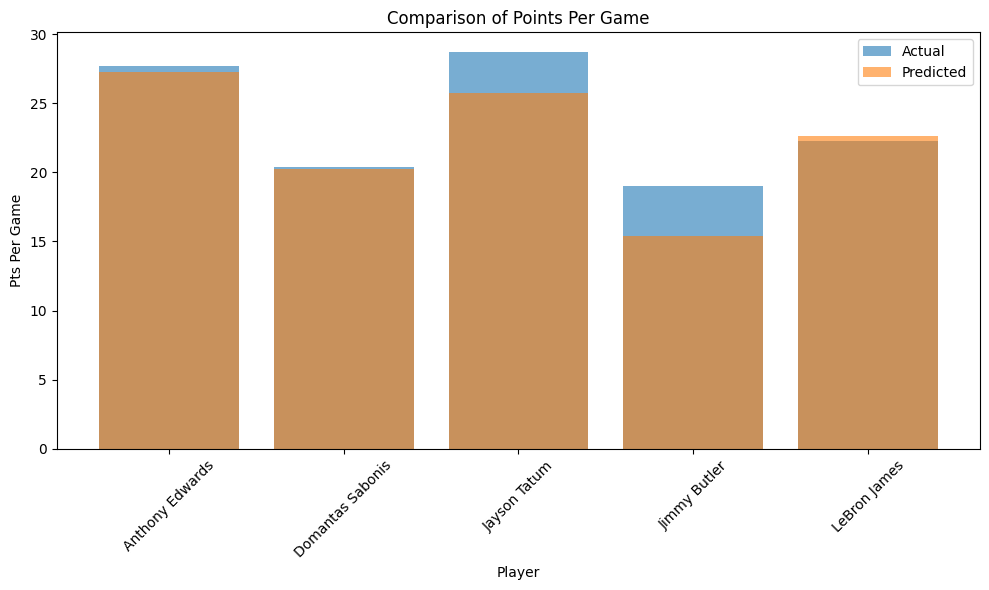

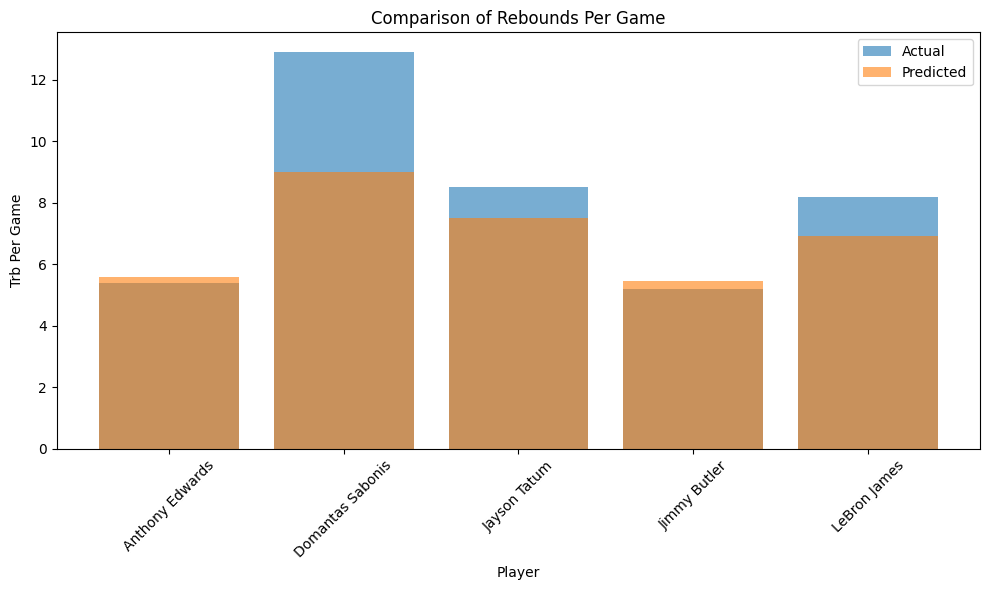

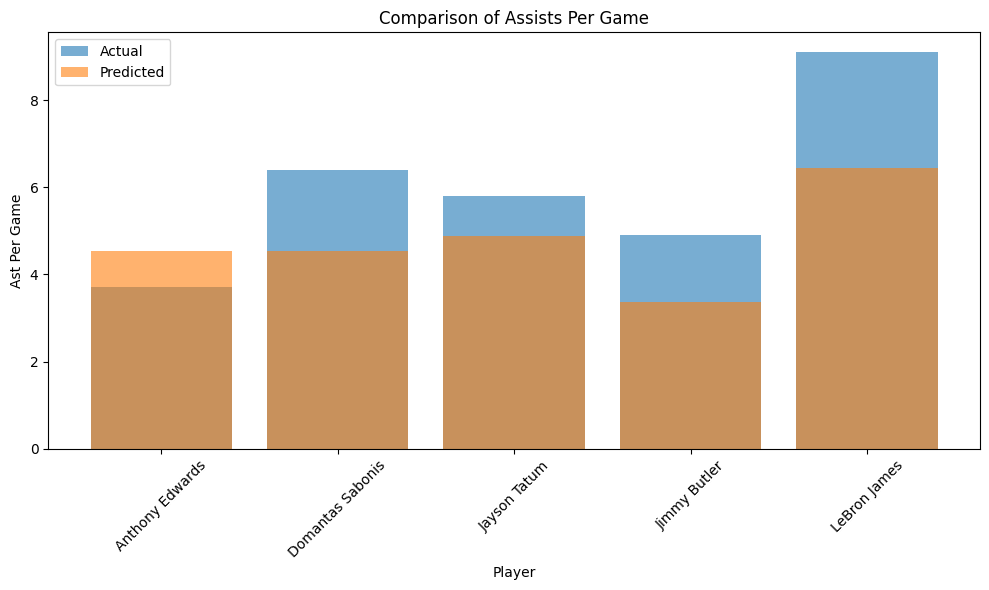

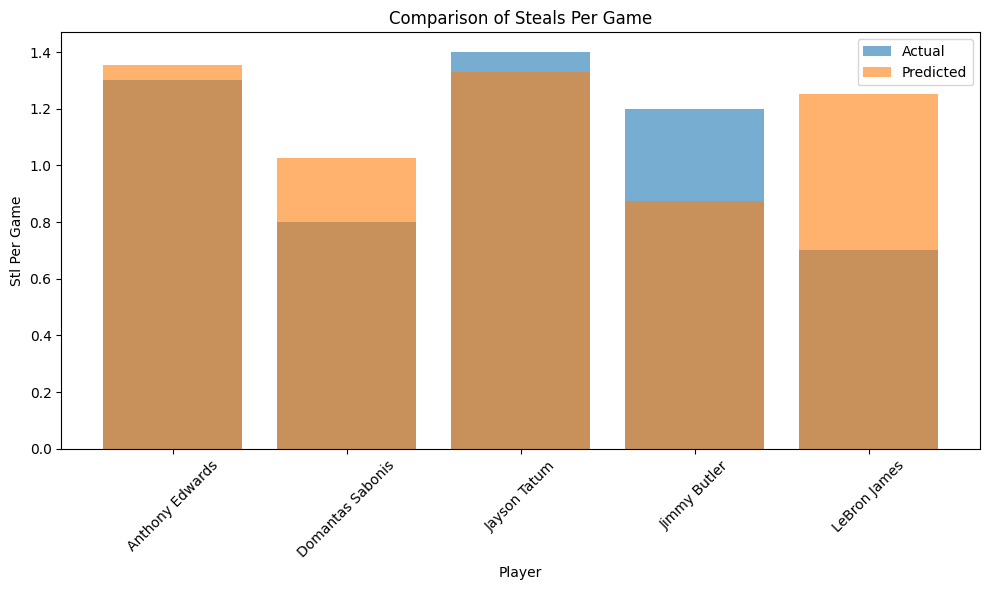

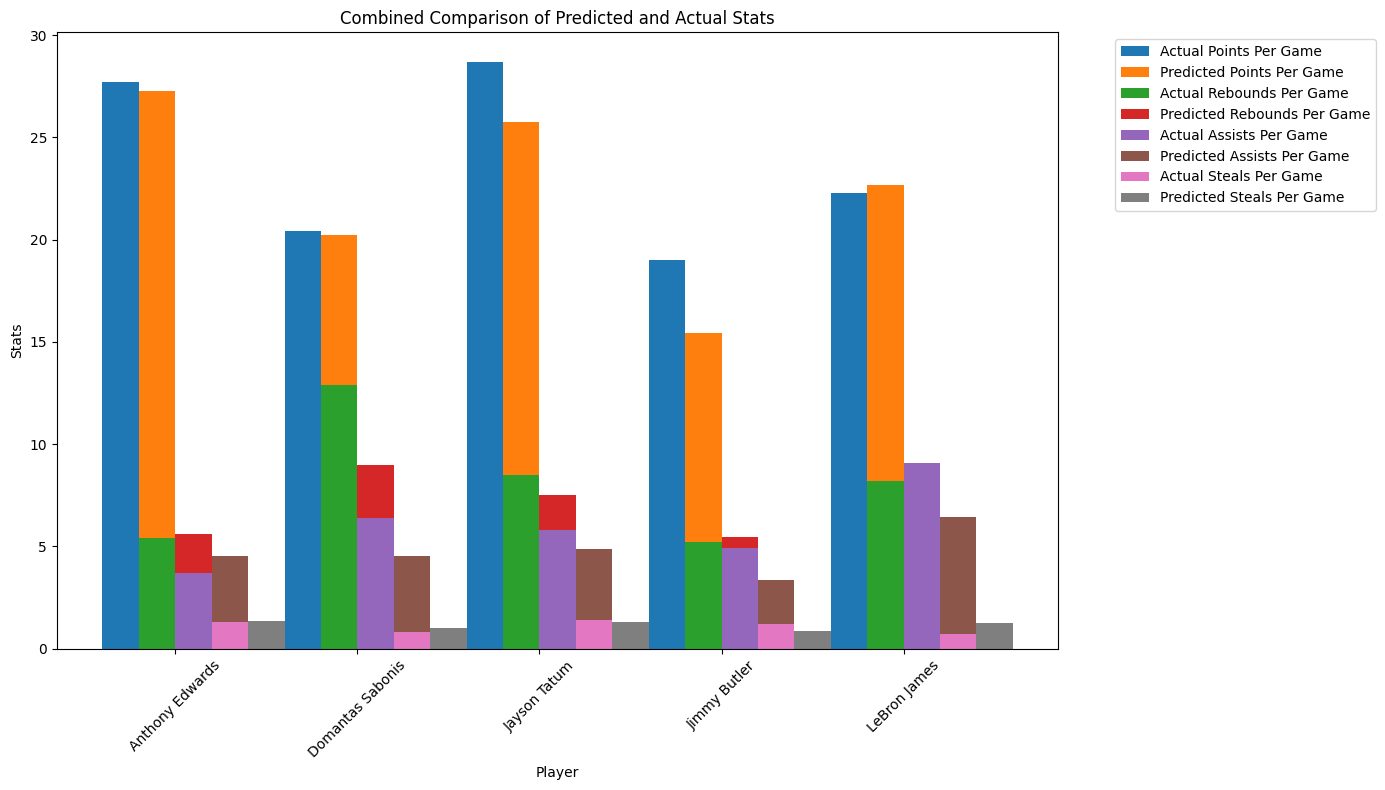

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Define stats and their corresponding titles for plotting
stats = ['pts_per_game', 'trb_per_game', 'ast_per_game', 'stl_per_game']
titles = ['Points Per Game', 'Rebounds Per Game', 'Assists Per Game', 'Steals Per Game']

# Bar plots for individual stats
for stat, title in zip(stats, titles):
    plt.figure(figsize=(10, 6))
    plt.bar(comparison['player'], comparison[f'{stat}_actual'], alpha=0.6, label='Actual')
    plt.bar(comparison['player'], comparison[f'{stat}_predicted'], alpha=0.6, label='Predicted')
    plt.xlabel('Player')
    plt.ylabel(stat.replace('_', ' ').title())
    plt.title(f'Comparison of {title}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Combined plot for all stats
plt.figure(figsize=(14, 8))
bar_width = 0.2
x = np.arange(len(comparison['player']))

for i, (stat, title) in enumerate(zip(stats, titles)):
    plt.bar(x + i * bar_width, comparison[f'{stat}_actual'], bar_width, label=f'Actual {title}')
    plt.bar(x + i * bar_width + bar_width, comparison[f'{stat}_predicted'], bar_width, label=f'Predicted {title}')

plt.xlabel('Player')
plt.ylabel('Stats')
plt.title('Combined Comparison of Predicted and Actual Stats')
plt.xticks(x + bar_width * (len(stats) / 2 - 0.5), comparison['player'], rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
